In [2]:
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [3]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from multiprocessing import Process
from tqdm import tqdm_notebook as tqdm
import pickle
from pathlib import Path
from nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R 
from math import cos, sin, pi
from lyft_dataset_sdk.lyftdataset import *
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.eval.detection import mAP_evaluation

In [4]:
import torch
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import build_network, example_convert_to_torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

## Read Config file

In [5]:
torch.set_num_threads(10)

# config_path = "../configs/nuscenes/all.fhd.config.2"
config_path = "/media/jionie/my_disk/Kaggle/Lyft/model/second/pipeline.config"
ckpt_path = "/media/jionie/my_disk/Kaggle/Lyft/model/second/voxelnet-235437.tckpt"

config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
# config_tool.change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']

## Build Network, Target Assigner and Voxel Generator

In [6]:
phase = 'train'
# phase = 'test'
folder = 'test' if phase == 'test' else 'train'
root = '/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/'
info_path = root + f'{folder}_root/infos_{phase}.pkl'
root_path = input_cfg.dataset.kitti_root_path # data/lyft/train

with open(info_path, 'rb') as f:
    infos = pickle.load(f)
    
print(info_path)

/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/train_root/infos_train.pkl


In [7]:
token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info

In [8]:
net = build_network(config.model.second).to(device).float().eval()
net.load_state_dict(torch.load(ckpt_path))
eval_input_cfg = config.eval_input_reader
eval_input_cfg.dataset.kitti_root_path = root_path
eval_input_cfg.dataset.kitti_info_path = info_path
batch_size = 2
num_workers = 4
dataset = input_reader_builder.build(
    eval_input_cfg,
    config.model.second,
    training=False,
    voxel_generator=net.voxel_generator,
    target_assigner=net.target_assigner)#.dataset
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size, # only support multi-gpu train
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    collate_fn=merge_second_batch)

classes = net.target_assigner.classes
np.array(classes)

array(['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle',
       'other_vehicle', 'motorcycle', 'pedestrian', 'truck'], dtype='<U17')

### utility functions

In [9]:
def thresholded_pred(pred, threshold):
    pred = deepcopy(pred)
    try:
        box3d = pred["box3d_lidar"].detach().cpu().numpy()
        scores = pred["scores"].detach().cpu().numpy()
        labels = pred["label_preds"].detach().cpu().numpy()
    except:
        box3d = pred["box3d_lidar"]#.detach().cpu().numpy()
        scores = pred["scores"]#.detach().cpu().numpy()
        labels = pred["label_preds"]#.detach().cpu().numpy()
        pass
    idx = np.where(scores > threshold)[0]
    # filter low score ones
    box3d = box3d[idx, :]
    # label is one-dim
    labels = np.take(labels, idx)
    scores = np.take(scores, idx)
    pred['box3d_lidar'] = box3d
    pred['scores'] = scores
    pred['label_preds'] = labels
    return pred

In [10]:
def to_glb(box, info):
    # lidar -> ego -> global
    # info should belong to exact same element in `gt` dict
    box.rotate(Quaternion(info['lidar2ego_rotation']))
    box.translate(np.array(info['lidar2ego_translation']))
    '''
    # filter det in ego.
    cls_range_map = eval_detection_configs[eval_version]["class_range"]
    radius = np.linalg.norm(box.center[:2], 2)
    det_range = cls_range_map[classes[box.label]]
    if radius > det_range:
        continue
    '''
    box.rotate(Quaternion(info['ego2global_rotation']))
    box.translate(np.array(info['ego2global_translation']))
    return box

In [11]:
from nuscenes.eval.detection.utils import *

In [29]:
def get_pred_glb(pred, sample_token, form='str'):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a `sample` token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2 # second to lyft format
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = scores[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            token=sample_token
        )
        #return box
        box = to_glb(box, info)
        if form=='str':
#             yaw = 2*np.arccos(box.orientation)
            pred =  str(box.score) + ' ' + str(box.center[0])  + ' '  + \
                    str(box.center[1]) + ' '  + str(box.center[2]) + ' '  + \
                    str(box.wlh[0]) + ' ' \
                    + str(box.wlh[1]) + ' '  + str(box.wlh[2]) + ' ' + str(box.orientation.yaw_pitch_roll[0]) + ' ' \
                    + str(name) + ' ' 
            pred_str += pred
        else:
            boxes.append(box)
    if form=='str':
        return pred_str.strip()
    else:
        return boxes

In [13]:
def torch2np(pred):
    f = lambda x: x.detach().cpu().numpy()
    pred["box3d_lidar"] = f(pred["box3d_lidar"])
    pred["scores"] = f(pred["scores"])
    pred["label_preds"] = f(pred["label_preds"])
    return pred

Generate raw predictions and save them in pickle format

In [14]:
%%notify
detections = []
#tokens = []
tk0 = tqdm(dataloader, total=len(dataloader))
for idx, examples in enumerate(tk0):
    try:
        example_torch = example_convert_to_torch(examples, device=device)
        dets = net(example_torch)
        detections += [torch2np(det) for det in dets]
    except Exception as e:
        print(e)
        import pdb; pdb.set_trace()

100%|██████████| 9261/9261 [36:07<00:00,  6.17it/s]


<IPython.core.display.Javascript object>

In [15]:
det_folder = os.path.join(os.path.dirname(ckpt_path), 'detections')
os.makedirs(det_folder, exist_ok=True)
det_file = os.path.join(det_folder, f"{ckpt_path.split('/')[-1].split('.')[0]}_{phase}.pkl")
print(det_file)

with open(det_file, 'wb') as f:
    pickle.dump(detections, f)
print(f'Saved detections at {det_file}')
print(f'python eval.py --det_file {det_file}  --phase {phase}') # eval.py command

/media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_train.pkl
Saved detections at /media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_train.pkl
python eval.py --det_file /media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_train.pkl  --phase train


### detection -> PredictionString

In [42]:
# with open(det_file, 'rb') as f:
#     detections = pickle.load(f)

NOTE: the `detections` are in raw format

In [17]:
if phase == 'train':
    col = 'PredictionStringtest'
    df = pd.read_csv(root + 'train_root/train.csv')
else:
    col = 'PredictionString'
    df = pd.read_csv(root + 'test_root/sample_submission.csv')

In [30]:
%%notify
threshold = 0.2
for idx, pred in enumerate(tqdm(detections)):
    pred = thresholded_pred(pred, threshold)
    token = pred['metadata']['token']
    pred_str = get_pred_glb(pred, token)
    index = df[df['Id'] == token].index[0]
    df.loc[index, col] = pred_str

100%|██████████| 18522/18522 [02:26<00:00, 126.59it/s]


<IPython.core.display.Javascript object>

In [31]:
df.to_csv('/media/jionie/my_disk/Kaggle/Lyft/model/second/submissions/all.pp.lowa.235k.0.2.csv', index=False)

In [32]:
df.head()

,Id,PredictionString,PredictionStringtest
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...,NaN
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...,0.8721659183502197 1186.8918847792106 1594.724...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...,NaN
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...,0.8390576243400574 1946.001885830691 1143.1754...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...,0.7902207970619202 1077.4268353901023 1663.459...


### testing on val set

make sure to match kernel is predicting on train or val which one

In [26]:
phase = 'train'
data = 'v1.0-trainval' if phase=='train' else 'v1.0-test'
lyft = LyftDataset(data_path=f'/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/{phase}_root/', \
                   json_path=f'/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/{phase}_root/{data}/', \
                   verbose=0) 
##nusc = NuScenes(dataroot=f'../../data/lyft/{phase}/', version=data, verbose=0) 

In [34]:
# info_path = input_cfg.dataset.kitti_info_path
# root_path = Path(input_cfg.dataset.kitti_root_path)
# info_path = '../../data/lyft/test/infos_test.pkl'
# root_path = '../../data/lyft/test/'

classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']
res_path = '/media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_train.pkl'
info_path = f'/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/{phase}_root/infos_train.pkl'
with open(res_path, 'rb') as f:
    results = pickle.load(f)#['infos']
    
with open(info_path, 'rb') as f:
    gt = pickle.load(f)['infos']

# info_val.pkl and result.pkl are a list of dictionaries, which are out of order, sorting them acc to token
gt = sorted(gt, key=lambda x: x['token'])
results = sorted(results, key=lambda x: x['metadata']['token'])
# sanity check
for i in range(len(gt)):
    assert gt[i]['token'] == results[i]['metadata']['token']
    results[i]['box3d_lidar'] = results[i]['box3d_lidar']#.detach().cpu().numpy()
    results[i]['scores'] = results[i]['scores']#.cpu().numpy()
    results[i]['label_preds'] = results[i]['label_preds']#.detach().cpu().numpy()


In [35]:
token2idx = {} # to match up with kernel_pred_boxes
for i in range(len(gt)):
    token2idx[gt[i]['token']] = i

In [36]:
def get_pred_boxes(pred, sample_token):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a `sample` token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = scores[idx]
        label = boxes_class[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=sample_token
        )
        boxes.append(box)
    return boxes

In [37]:
threshold = 0.3
token2predstr = {}
for idx in tqdm(range(len(dataset))):
    idx=100
    example = dataset[idx]
    token = example['metadata']['token']
    #print('token:', token)
    # don't forget to pad batch idx in coordinates
    example["coordinates"] = np.pad(
        example["coordinates"], ((0, 0), (1, 0)),
        mode='constant',
        constant_values=0)
    # don't forget to add newaxis for anchors
    example["anchors"] = example["anchors"][np.newaxis, ...]

    example_torch = example_convert_to_torch(example, device=device)
    pred = net(example_torch)[0]
    pred = thresholded_pred(pred, threshold)
    sample_token = example['metadata']['token']
    kernel_pred_boxes = get_pred_boxes(pred, sample_token)
    break
pkl_idx = token2idx[token] 
idx, pkl_idx

  0%|          | 0/18522 [00:00<?, ?it/s]


(100, 3747)

we have `kernel_pred_boxes` predicted on given `idx` and `token` by this kernel, we have `results[pkl_idx]` predicted during training, we have ground truth in `gt[pkl_idx]['gt_boxes']` as actual ground truth + lyft.get_boxes for ground truth, all in lidar's FoR

In [38]:
info_gt = gt[pkl_idx].copy() # during training predictions
info_gt['gt_boxes'].shape
info_gt['gt_boxes'].shape
gt[0].keys()

dict_keys(['lidar_path', 'cam_front_path', 'token', 'sweeps', 'lidar2ego_translation', 'lidar2ego_rotation', 'ego2global_translation', 'ego2global_rotation', 'timestamp', 'gt_boxes', 'gt_names', 'gt_velocity', 'num_lidar_pts', 'num_radar_pts'])

In [39]:
def gt2Box(gt_boxes, gt_names, token):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
        yaw = - gt_boxes[idx, 6] - pi/2
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes


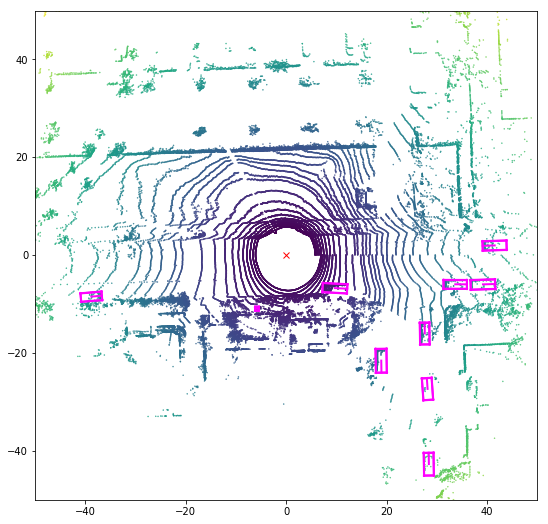

In [40]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's FoR, we get the ground truth boxes in lidar's FoR too.
info = token2info[token]

dt_pred = results[pkl_idx].copy() # during training predictions
dt_pred = thresholded_pred(dt_pred, threshold)
dt_pred_boxes = get_pred_boxes(dt_pred, token)

gt_info = gt[pkl_idx]
info_gt_boxes = gt_info['gt_boxes'].copy() # during training predictions
info_gt_names = gt_info['gt_names'].copy() # during training predictions
info_gt_boxes = gt2Box(info_gt_boxes, info_gt_names, token)

v_path = info["lidar_path"]
points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

# plot kernel predictions
for pbox in kernel_pred_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('cone')) / 255.0 # black
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 
    
# plot detection results.pkl 
for pbox in dt_pred_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('pedestrian')) / 255.0 # Blue 
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 
    
# plot ground truth from info.pkl 
for pbox in info_gt_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('vehicle.bicycle')) / 255.0 # Red 
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 

lidar_token = lyft.get('sample', info['token'])['data']['LIDAR_TOP']
_, gt_boxes, _ = lyft.get_sample_data(lidar_token, flat_vehicle_coordinates=False) # notice flat_vehicle_coordinates=False 
for box in gt_boxes:
#     print(box)
#     break
    c = np.array(lyft.explorer.get_color('animal')) / 255.0 # magenta 
    box.render(ax, view=np.eye(4), colors=(c, c, c))

##### Conclusion

* The `results.pkl` generated during training are more or less same as predictions made by this kernel
* my pred boxes to Box conversion code is perfect :D, because gt_boxes matches with lyft.get_boxes()

### What next?
* predict on val set, get them to global, compare with ground truth predstring


In [48]:
phase = 'val'
# phase = 'test'
folder = 'test' if phase == 'test' else 'train'
root = '/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/'
info_path = root + f'{folder}_root/infos_val.pkl'
root_path = input_cfg.dataset.kitti_root_path # data/lyft/train

with open(info_path, 'rb') as f:
    infos = pickle.load(f)
    
print(info_path)

/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/train_root/infos_val.pkl


In [45]:
token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info

In [46]:
eval_input_cfg = config.eval_input_reader
eval_input_cfg.dataset.kitti_root_path = root_path
eval_input_cfg.dataset.kitti_info_path = info_path
batch_size = 2
num_workers = 4
dataset = input_reader_builder.build(
    eval_input_cfg,
    config.model.second,
    training=False,
    voxel_generator=net.voxel_generator,
    target_assigner=net.target_assigner)#.dataset
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size, # only support multi-gpu train
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    collate_fn=merge_second_batch)

classes = net.target_assigner.classes
np.array(classes)

array(['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle',
       'other_vehicle', 'motorcycle', 'pedestrian', 'truck'], dtype='<U17')

In [47]:
%%notify
detections = []
#tokens = []
tk0 = tqdm(dataloader, total=len(dataloader))
for idx, examples in enumerate(tk0):
    try:
        example_torch = example_convert_to_torch(examples, device=device)
        dets = net(example_torch)
        detections += [torch2np(det) for det in dets]
    except Exception as e:
        print(e)
        import pdb; pdb.set_trace()

100%|██████████| 2079/2079 [08:17<00:00,  7.18it/s]


<IPython.core.display.Javascript object>

In [49]:
det_folder = os.path.join(os.path.dirname(ckpt_path), 'detections')
os.makedirs(det_folder, exist_ok=True)
det_file = os.path.join(det_folder, f"{ckpt_path.split('/')[-1].split('.')[0]}_{phase}.pkl")
print(det_file)

with open(det_file, 'wb') as f:
    pickle.dump(detections, f)
print(f'Saved detections at {det_file}')
print(f'python eval.py --det_file {det_file}  --phase {phase}') # eval.py command

/media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_val.pkl
Saved detections at /media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_val.pkl
python eval.py --det_file /media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_val.pkl  --phase val


In [65]:
res_path = '/media/jionie/my_disk/Kaggle/Lyft/model/second/detections/voxelnet-235437_val.pkl'
info_path = f'/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/train_root/infos_val.pkl'
with open(res_path, 'rb') as f:
    results = pickle.load(f)#['infos']
    
with open(info_path, 'rb') as f:
    gt = pickle.load(f)['infos']

gt = sorted(gt, key=lambda x: x['token'])
results = sorted(results, key=lambda x: x['metadata']['token'])
# sanity check
for i in range(len(gt)):
    assert gt[i]['token'] == results[i]['metadata']['token']
    results[i]['box3d_lidar'] = results[i]['box3d_lidar']#.detach().cpu().numpy()
    results[i]['scores'] = results[i]['scores']#.cpu().numpy()
    results[i]['label_preds'] = results[i]['label_preds']#.detach().cpu().numpy()

In [42]:
def toBox3D(box, info):
    return mAP_evaluation.Box3D(
                sample_token=info['token'],
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

### val df pred vs gt

In [69]:
df = pd.read_csv('/media/jionie/my_disk/Kaggle/Lyft/model/second/submissions/all.pp.lowa.235k.0.2.csv')
val_df = df[df.PredictionStringtest.notna()]
pred_df = val_df.copy()

In [70]:
pred_df.head()

,Id,PredictionString,PredictionStringtest
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...,0.8721659183502197 1186.8918847792106 1594.724...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...,0.8390576243400574 1946.001885830691 1143.1754...
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...,0.7902207970619202 1077.4268353901023 1663.459...
6,dfd82bb815996179b54e6271dc4a11294b4c608117efb9...,2898.6051446136653 562.5216374000888 -17.87993...,0.8391342163085938 2907.947772229316 538.97937...
7,1fcd76b821316194199d7c5f65bafff335ae2ee000d649...,1069.794595095304 1701.507156901828 -23.592075...,0.8624001145362854 1117.618730146944 1660.6188...


In [71]:
def get2Box(gt_boxes, gt_names, token, scores=None):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
        yaw = gt_boxes[idx, 6]
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 # for ground truths 
        if scores is not None:
            detection_score = scores[idx]
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes


In [72]:
classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']

In [73]:
def get_pred_gt(idx): 
    sample_token = pred_df.iloc[idx]['Id']
    ps = pred_df.iloc[idx]['PredictionString'].split()
    gt_objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
    ps = pred_df.iloc[idx]['PredictionStringtest'].split()
    pred_objects = [ps[x:x+9] for x in range(0, len(ps), 9)]
    # str -> float, in x,y,z,w,l,h,yaw format
    gt_boxes = np.array([list(map(float, x[0:7])) for x in gt_objects])
    gt_class = np.array([x[7] for x in gt_objects])
    pred_scores = np.array([float(x[0]) for x in pred_objects])
    pred_boxes = np.array([list(map(float, x[1:8])) for x in pred_objects])
    pred_class = np.array([x[8] for x in pred_objects])
    # xyzwlhyaw-> Box instance
    predBoxes = get2Box(pred_boxes, pred_class, sample_token, scores=pred_scores)
    gtBoxes = get2Box(gt_boxes, gt_class, sample_token)
    return predBoxes, gtBoxes 

In [74]:
def toBox3D(box, sample_token):
    return mAP_evaluation.Box3D(
                sample_token=sample_token,
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

def serialize(box):
    return {
        'sample_token': box.token,
        'translation': list(box.center),
        'size': list(box.wlh),
        'rotation': list(box.orientation.elements),
        'name': box.name,
        'score': box.score
    }

In [75]:
# get all boxes per sample in a list
predBoxes = []
gtBoxes = []
for idx in tqdm(range(len(pred_df))):
    pb, gb = get_pred_gt(idx)
    predBoxes.append(pb)
    gtBoxes.append(gb)

100%|██████████| 18520/18520 [00:45<00:00, 404.82it/s] 


In [76]:
# box instance to Box3D instance -> used for mAP calculation
pboxes = []
for boxes in tqdm(predBoxes):
    for box in boxes:
        box = serialize(box)
        pboxes.append(box)
    
gboxes = []
for boxes in tqdm(gtBoxes):
    for box in boxes:
        box = serialize(box)
        gboxes.append(box)

100%|██████████| 18520/18520 [00:02<00:00, 7043.52it/s] 


In [77]:
# a dict with class name as key and all corresponding boxes in value
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

In [78]:
# take a look
for name in classes:
    print(name, 'gt/pred:', len(gt_by_class_name[name]), len(pred_by_class_name[name]))

car gt/pred: 439281 390388
bicycle gt/pred: 17935 9560
animal gt/pred: 114 0
bus gt/pred: 6584 6278
emergency_vehicle gt/pred: 100 0
other_vehicle gt/pred: 26438 12668
motorcycle gt/pred: 673 182
pedestrian gt/pred: 21059 11194
truck gt/pred: 12091 4333


In [79]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import *

In [80]:
def get_ap(gt, predictions, class_names, iou_threshold, output_dir):
    ap = get_average_precisions(gt, predictions, class_names, iou_threshold)
    metric = {c:ap[idx] for idx, c in enumerate(class_names)}
    summary_path = output_dir / f'metric_summary_{iou_threshold}.json'
    with open(str(summary_path), 'w') as f:
        json.dump(metric, f)

In [81]:
%%notify
output_dir = Path('./tmp')
iou_th_range = np.linspace(0.5, 0.95, 10) # 0.5, 0.55, ..., 0.90, 0.95

def run_processes(start, end):
    processes = []
    for idx in range(0, 3):
        iou_threshold = iou_th_range[idx]
        process = Process(target=get_ap, args=(gboxes, pboxes, classes, iou_threshold, output_dir))
        processes.append(process)
        process.start()
    for process in processes:
        process.join()   

run_processes(0, 3)
run_processes(3, 6)
run_processes(6, 10)

Process Process-10:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-80-e4509fc9e292>", line 5, in get_ap
    with open(str(summary_path), 'w') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'tmp/metric_summary_0.55.json'
Process Process-9:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-80-e4509fc9e292>", line 5, in get_ap
    with open(str(summary_path), 'w') as f:
FileNotFoundError: [Errno 2] No such file or directory: 'tmp/metric_summary_0.5.json'
Process Process-11:
Traceback (most recent call last):
  File "/usr/lib/python3.6/mu

<IPython.core.display.Javascript object>

In [82]:
average_precisions = np.zeros(len(classes))

iou_th_range = np.linspace(0.5, 0.95, 10) # 0.5, 0.55, ..., 0.90, 0.95
for idx, iou_threshold in enumerate(tqdm(iou_th_range)):
    for class_id, class_name in enumerate(classes):
        if class_name in pred_by_class_name and class_name in gt_by_class_name:
            if len(gt_by_class_name[class_name]):
                recalls, precisions, average_precision = mAP_evaluation.recall_precision(
                    gt_by_class_name[class_name], pred_by_class_name[class_name], iou_threshold
                )
                average_precisions[class_id] += average_precision
    print(idx, average_precisions / (idx+1))
average_precisions /= 10.0
for idx, name in enumerate(classes):
    print(f'class: {name}: {average_precisions[idx]}')
    
mAP = average_precisions.mean()
print(f'\nOverall mAP: {mAP}')

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
average_precisions[average_precisions.nonzero()[0]].mean()

### sanity check

we have `predBoxes` and `gBoxes` in `Box` format

In [86]:
phase = 'train'
data = 'v1.0-trainval' if phase=='train' else 'v1.0-test'
lyft = LyftDataset(data_path=f'/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/{phase}_root/', \
                   json_path=f'/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/{phase}_root/{data}/', \
                   verbose=0) 

In [87]:
from copy import deepcopy

In [88]:
def glb_to_sensor(box, lidar):
    box = deepcopy(box) # v.imp
    cs_record = lyft.get('calibrated_sensor', lidar['calibrated_sensor_token'])
    pose_record = lyft.get('ego_pose', lidar['ego_pose_token'])
    box.translate(-np.array(pose_record['translation']))
    box.rotate(Quaternion(pose_record['rotation']).inverse)
    box.translate(-np.array(cs_record['translation']))
    box.rotate(Quaternion(cs_record['rotation']).inverse)
    return box

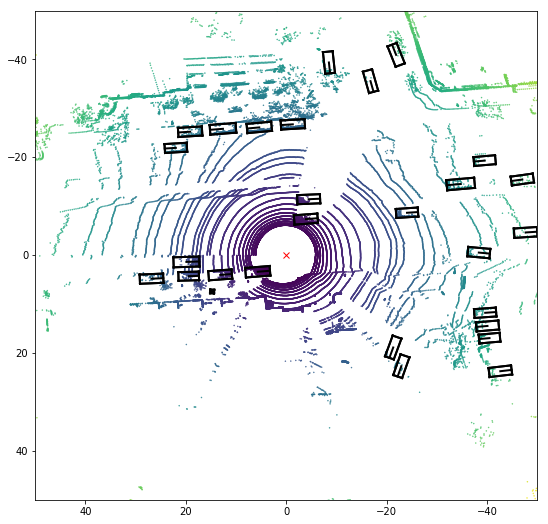

In [90]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's FoR, we get the ground truth boxes in lidar's FoR too.
idx = 0
axes_limit=40
sample_token = pred_df.iloc[idx]['Id']
sample = lyft.get('sample', sample_token)
lidar = lyft.get('sample_data', sample['data']['LIDAR_TOP'])
path = os.path.join(root, 'train_root/', lidar['filename'])
points = np.fromfile(path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

for box in predBoxes[idx]:
    if box.score < 0.3: break
    box = glb_to_sensor(box, lidar)
    c = np.array(LyftDatasetExplorer.get_color('cone')) / 255.0 # black
    box.render(ax, view=np.eye(4), colors=(c, c, c))
    
for box in gtBoxes[idx]:
    break
    box = glb_to_sensor(box, lidar)
    c = np.array(LyftDatasetExplorer.get_color('pedestrian')) / 255.0 #blue 
    box.render(ax, view=np.eye(4), colors=(c, c, c))
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

In [91]:
for box in predBoxes[idx]:
    print(box.score)

0.8721659183502197
0.849946141242981
0.8490185141563416
0.8428337574005127
0.8244578242301941
0.8236818313598633
0.8169777393341064
0.7865174412727356
0.7138006091117859
0.703587532043457
0.6957420110702515
0.6619927287101746
0.6455731987953186
0.5930079221725464
0.5907912850379944
0.577674925327301
0.5539151430130005
0.5514740347862244
0.5205369591712952
0.5001691579818726
0.46605703234672546
0.4487752914428711
0.42567986249923706
0.40212270617485046
0.39024534821510315
0.31923264265060425
0.31717339158058167
0.31108400225639343
0.29761457443237305
0.29541778564453125
0.28189682960510254
0.2786194384098053
0.2778289318084717
0.2528982162475586


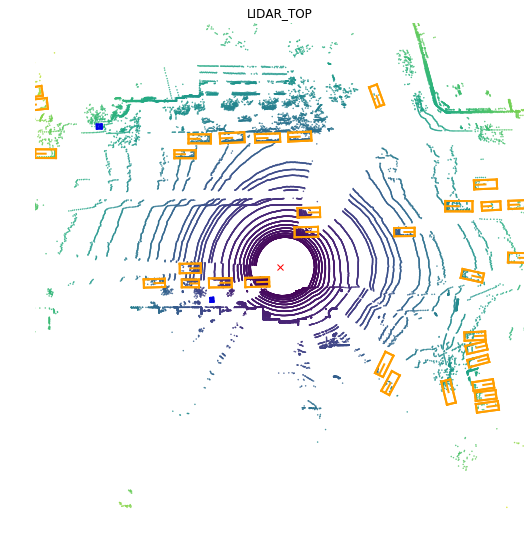

In [92]:
lyft.render_sample_data(lidar['token'], axes_limit=axes_limit)

In [104]:
phase = 'train'
# phase = 'test'
folder = 'test' if phase == 'test' else 'train'
root = '/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/'
info_path = root + f'{folder}_root/infos_{phase}.pkl'
root_path = input_cfg.dataset.kitti_root_path # data/lyft/train

with open(info_path, 'rb') as f:
    infos = pickle.load(f)
    
print(info_path)

token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info

info = token2info[token]
v_path = info["lidar_path"]
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]

/media/jionie/my_disk/Kaggle/Lyft/input/3d-object-detection-for-autonomous-vehicles/train_root/infos_train.pkl


In [105]:
sample = lyft.get('sample', info['token'])
lidar_token = sample['data']['LIDAR_TOP']
# lyft.render_sample_data(lidar_token)

In [106]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=1.0):
    '''Plot boxes in the 3d figure'''
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

In [107]:
def draw_3d_plot(lidar_token, boxes):
    '''Plot the lidar + annotations on a 3D figure'''
    # sample lidar point cloud
    lidar_points = get_lidar_points(lidar_token)
    points = 0.5 # fraction of lidar_points to plot, to reduce the clutter
    points_step = int(1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    lidar_points = lidar_points[:, pc_range]
    
    # Get boxes, instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
    #_, boxes, _ = lyft.get_sample_data(
    #    lidar_token, flat_vehicle_coordinates=True
    #)
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')                    
    point_size = 0.01 * (1. / points) # size of the dots on plot
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(*lidar_points, s=point_size, c='white', cmap='gray')
    for box in boxes:
        c = np.array(lyft.explorer.get_color(box.name)) / 255.0
        plot_box(box, ax, view=np.eye(3), colors=(c, c, c), linewidth=1)
    ax.set_xlim3d(-40, 40)
    ax.set_ylim3d(-40, 40)
    ax.set_zlim3d(-4, 40)
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title(lidar_token, color='white')
#     filename = 'tmp/frame_{0:0>4}.png'.format(idx)
#     plt.savefig(filename)
#     plt.close(fig)
    plt.show()
#     return filename

In [108]:
def get_lidar_points(lidar_token):
    '''Get lidar point cloud in the frame of the ego vehicle'''
    sd_record = lyft.get("sample_data", lidar_token)
    sensor_modality = sd_record["sensor_modality"]
    
    # Get aggregated point cloud in lidar frame.
    sample_rec = lyft.get("sample", sd_record["sample_token"])
    chan = sd_record["channel"]
    ref_chan = "LIDAR_TOP"
    pc, times = LidarPointCloud.from_file_multisweep(
        lyft, sample_rec, chan, ref_chan, num_sweeps=1
    )
    # Compute transformation matrices for lidar point cloud
    cs_record = lyft.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
    pose_record = lyft.get("ego_pose", sd_record["ego_pose_token"])
    vehicle_from_sensor = np.eye(4)
    vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
    vehicle_from_sensor[:3, 3] = cs_record["translation"]
    
    ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
    rot_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
    )
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle
    points = view_points(
        pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
    )
    return points

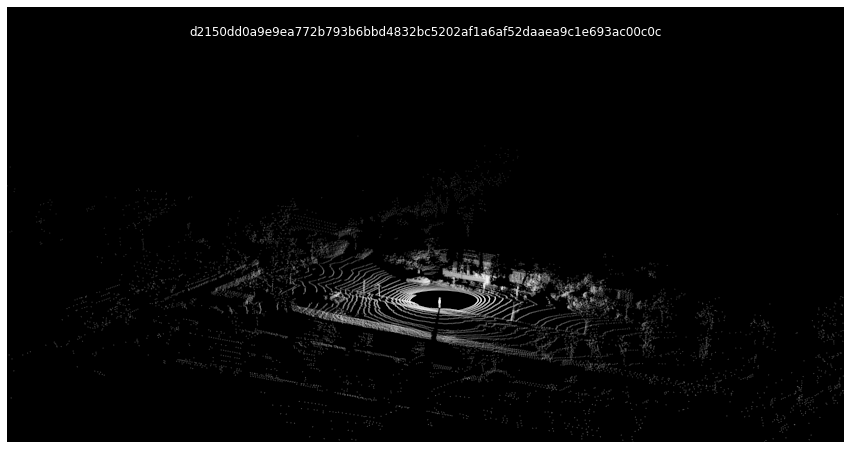

In [109]:
draw_3d_plot(lidar_token, boxes)

In [110]:
pc = get_lidar_points(sample['data']['LIDAR_TOP'])

In [111]:
pred.keys()

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata'])

In [113]:
box3d_lidar = pred['box3d_lidar']
scores = pred['scores']
label_preds = pred['label_preds']
metadata = pred['metadata']

In [114]:
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
org_bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(org_bev_map.copy(), vis_point_range, boxes_lidar, [0, 255, 0], 2)

NameError: name 'boxes_lidar' is not defined

In [115]:
box3d_lidar.shape

(10, 7)

In [116]:
label_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
classes = target_assigner.classes

In [45]:

classes = target_assigner.classes
preds = [classes[x] for x in label_preds]
preds

['car',
 'car',
 'car',
 'car',
 'car',
 'bus',
 'bus',
 'bus',
 'car',
 'bus',
 'bus',
 'bus',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'car',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'car',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'car',


In [ ]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

In [ ]:
img_id = train.iloc[0]['Id']
ps = train.iloc[0]['PredictionString']
ps = ps.split()
objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
len(objects), objects[0]

In [285]:
train.iloc[0]['PredictionString']

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778

### evaluation test

In [20]:
pred_df = pd.read_csv('submissions/all.fhd.2.val.csv')
# pred_df = val_df.copy()

In [21]:
pred_df.head()

,Id,PredictionString,PredictionStringtest
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...,0.9132686257362366 2719.266457575167 690.86441...
1,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...,0.9026079177856445 872.4775161488055 2564.1953...
2,4131c08a60bb7ad7fa66beb76f609d478571d508075a5a...,2775.313471140576 647.6817293876779 -18.164804...,0.9325973987579346 2681.6541244227205 705.8557...
3,7ff737ffb6f4d3adc01934f07178002543b6aab2352b1e...,2057.870673628988 1069.1471751137874 -18.38568...,0.9309068918228149 2030.8163891821255 1078.934...
4,5796b008cea965d2ff1d8f653d93b5d29aed64c22d6b89...,1426.2092077593366 1476.2266591045304 -21.5862...,0.914925217628479 1423.4485303394708 1473.6644...


In [22]:
def get2Box(gt_boxes, gt_names, token, scores=None):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
#         yaw = - gt_boxes[idx, 6] - pi/2 # no need for this, already in global form (not second format)
        yaw = gt_boxes[idx, 6]
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 # for ground truths 
        if scores is not None:
            detection_score = scores[idx]
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes


In [23]:
classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']

In [24]:
def get_pred_gt(idx): 
    sample_token = pred_df.iloc[idx]['Id']
    ps = pred_df.iloc[idx]['PredictionString'].split()
    gt_objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
    ps = pred_df.iloc[idx]['PredictionStringtest'].split()
    pred_objects = [ps[x:x+9] for x in range(0, len(ps), 9)]
    # str -> float, in x,y,z,w,l,h,yaw format
    gt_boxes = np.array([list(map(float, x[0:7])) for x in gt_objects])
    gt_class = np.array([x[7] for x in gt_objects])
    pred_scores = np.array([float(x[0]) for x in pred_objects])
    pred_boxes = np.array([list(map(float, x[1:8])) for x in pred_objects])
    pred_class = np.array([x[8] for x in pred_objects])
    # xyzwlhyaw-> Box instance
    predBoxes = get2Box(pred_boxes, pred_class, sample_token, scores=pred_scores)
    gtBoxes = get2Box(gt_boxes, gt_class, sample_token)
    return predBoxes, gtBoxes 

In [25]:
def toBox3D(box, sample_token):
    return mAP_evaluation.Box3D(
                sample_token=sample_token,
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

def serialize(box):
    return {
        'sample_token': box.token,
        'translation': list(box.center),
        'size': list(box.wlh),
        'rotation': list(box.orientation.elements),
        'name': box.name,
        'score': box.score
    }

In [26]:
# get all boxes per sample in a list
predBoxes = []
gtBoxes = []
for idx in tqdm(range(len(pred_df))):
    pb, gb = get_pred_gt(idx)
    predBoxes.append(pb)
    gtBoxes.append(gb)

100%|██████████| 4032/4032 [00:08<00:00, 499.30it/s] 


In [27]:
# box instance to Box3D instance -> used for mAP calculation
pboxes = []
for boxes in tqdm(predBoxes):
    for box in boxes:
        box = serialize(box)
        pboxes.append(box)
    
gboxes = []
for boxes in tqdm(gtBoxes):
    for box in boxes:
        box = serialize(box)
        gboxes.append(box)

100%|██████████| 4032/4032 [00:00<00:00, 4158.23it/s]


In [28]:
# a dict with class name as key and all corresponding boxes in value
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

In [29]:
# take a look
for name in classes:
    print(name, 'gt/pred:', len(gt_by_class_name[name]), len(pred_by_class_name[name]))

car gt/pred: 93364 76825
bicycle gt/pred: 2949 1578
animal gt/pred: 72 0
bus gt/pred: 2133 1564
emergency_vehicle gt/pred: 0 0
other_vehicle gt/pred: 6916 6377
motorcycle gt/pred: 145 4
pedestrian gt/pred: 3876 2077
truck gt/pred: 2073 1990


In [38]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import *

In [53]:
class_name = 'bus'
gt = gt_by_class_name[class_name]
predictions = pred_by_class_name[class_name]
iou_threshold = 0.2
num_gts = len(gt)
image_gts = group_by_key(gt, "sample_token")
image_gts = wrap_in_box(image_gts)

sample_gt_checked = {sample_token: np.zeros(len(boxes)) for sample_token, boxes in image_gts.items()}

predictions = sorted(predictions, key=lambda x: x["score"], reverse=True)

# go down dets and mark TPs and FPs
num_predictions = len(predictions)
tp = np.zeros(num_predictions)
fp = np.zeros(num_predictions)

In [59]:
len(gt), len(predictions) # total 1564 predictions, they can either be TP or FP

(2133, 1564)

In [60]:
for prediction_index, prediction in enumerate(tqdm(predictions)):
    # take each prediction
    predicted_box = Box3D(**prediction)

    sample_token = prediction["sample_token"]

    max_overlap = -np.inf
    jmax = -1

    try:
        gt_boxes = image_gts[sample_token]  # gt_boxes per sample
        gt_checked = sample_gt_checked[sample_token]  # gt flags per sample
    except KeyError:
        gt_boxes = []
        gt_checked = None

    if len(gt_boxes) > 0:
        # get overlap of this predicted box with all the ground truths
        overlaps = get_ious(gt_boxes, predicted_box)
        # get the one, with which it has the maximum overlap
        max_overlap = np.max(overlaps)
        jmax = np.argmax(overlaps)

    if max_overlap > iou_threshold: # the max overlapping box qualifies the threshold
        if gt_checked[jmax] == 0: # if this gt box isn't checked (already identified by a pred box)
            tp[prediction_index] = 1.0
            gt_checked[jmax] = 1
        else: # if this pred box was already "assigned" to any ground truth, then you predicted a box close to the ground truth, but there was another box predicted which was better
            # so this is a false positive
            fp[prediction_index] = 1.0
    else: # there was no ground truth for this predictions
        fp[prediction_index] = 1.0


100%|██████████| 1564/1564 [00:00<00:00, 3798.51it/s]


In [65]:
fp.sum(), tp.sum()

(1288.0, 276.0)

In [66]:
# compute precision recall
fp = np.cumsum(fp, axis=0)
tp = np.cumsum(tp, axis=0)

In [70]:
fp, tp # cummulative sum

(array([1.000e+00, 2.000e+00, 2.000e+00, ..., 1.286e+03, 1.287e+03,
        1.288e+03]), array([  0.,   0.,   1., ..., 276., 276., 276.]))

In [71]:
recalls = tp / float(num_gts) # num_gts = total positives, there's no TN predictions here! damn, we do have FNs though but not in predicted boxes but in ground truths 

In [73]:
recalls

array([0.        , 0.        , 0.00046882, ..., 0.12939522, 0.12939522,
       0.12939522])

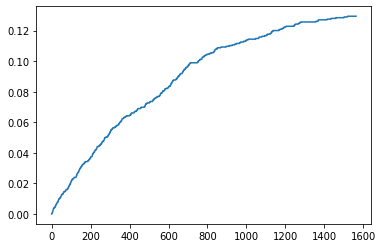

In [77]:
plt.plot(recalls)

In [78]:
# avoid divide by zero in case the first detection matches a difficult ground truth
precisions = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)

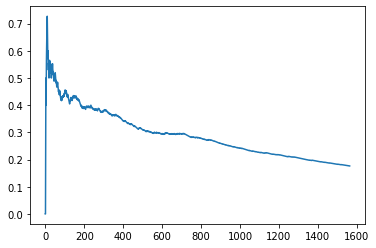

In [83]:
plt.plot(precisions)

 precision vs recall, is for a given recall max to min values of precision
<img width="500" height="500" src="https://miro.medium.com/max/1504/1*VenTq4IgxjmIpOXWdFb-jg.png"></img>

In [84]:
# correct AP calculation
# first append sentinel values at the end
recalls = np.concatenate(([0.0], recalls, [1.0]))
precisions = np.concatenate(([0.0], precisions, [0.0]))

In [90]:
recalls, precisions

(array([0.        , 0.        , 0.        , ..., 0.12939522, 0.12939522,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.17658349, 0.17647059,
        0.        ]))

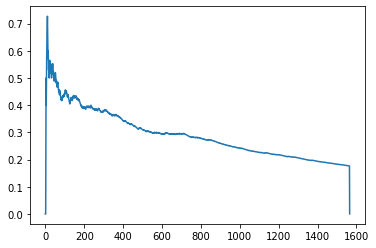

In [91]:
plt.plot(precisions)

In [92]:
#get_envelope, make it concave ?, smoothen out
for i in range(precisions.size - 1, 0, -1):
    precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

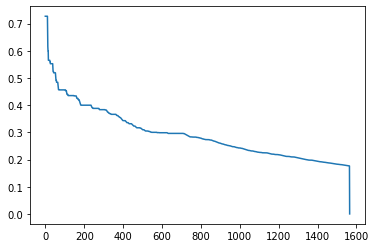

In [93]:
plt.plot(precisions)

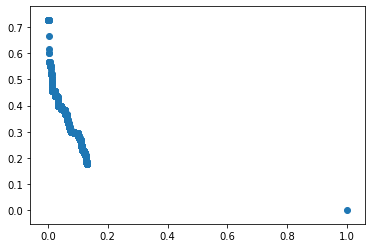

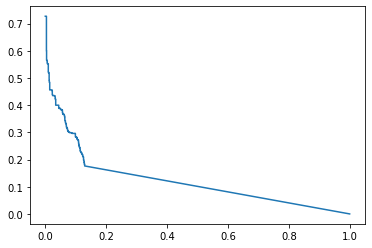

In [96]:
plt.scatter(recalls, precisions); plt.show()
plt.plot(recalls, precisions); plt.show()

In [97]:
recalls

array([0.        , 0.        , 0.        , ..., 0.12939522, 0.12939522,
       1.        ])

In [98]:
# to calculate area under PR curve, look for points where X axis (recall) changes value
i = np.where(recalls[1:] != recalls[:-1])[0]

In [102]:
(recalls[1:] != recalls[:-1])

array([False, False,  True, ..., False, False,  True])

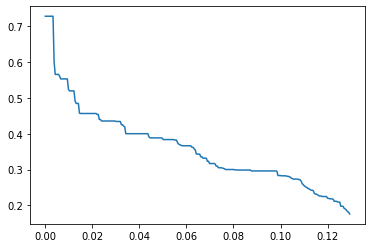

In [103]:
plt.plot(recalls[i], precisions[i]); plt.show()

In [104]:
# and sum (\Delta recall) * prec
ap = np.sum((recalls[i + 1] - recalls[i]) * precisions[i + 1])

In [105]:
ap

0.04677945150868475